# Library imports and parameters

In [ ]:
import time, os, sys, shutil, pathlib, random, math, csv

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

from IPython import display
from IPython.display import Audio
from google.colab import drive
from pathlib import Path
from datetime import datetime

AUTOTUNE = tf.data.AUTOTUNE
seed = 69 #Sets the randomisation seed, in order to get the same RNG each session
tf.random.set_seed(seed)
np.random.seed(seed)


#Parameters
gdrive_path = Path("/content/gdrive/MyDrive/Datasets") / ("MSWC_dataset_wavs/MSWC_keywords_wavs.zip") #Path to the dataset with wav files consisting of the selected keywords(located in googleDrive)
modelSavePath = Path("/content/gdrive/MyDrive/Saved_models/") #Path where to save the trained model, tfLite version will be saved in a new folder at this path
custom_dataset_path = Path("/content/gdrive/MyDrive/Datasets/Real-life_Verification/") #Path where custom wav files are located, used at the end for more testing of the trained model. Files need to be 16kHz .WAV files

modelType = "simpleCNN" #CNN architecture that will be used: "simpleCNN", "mobileNetV1", "mobileNetV2" or "mobileNetV3" or "efficientNet". Only simpleCNN works reliably
alphaMobileNet = 0.7 #MobileNet architecture widht/complexity setting (Value from 0.1 to 1.0)
dropoutMobileNet = 0.005 #MobileNetV1 dropout setting (0.001 default)
datasetType = "MSWC" #Dataset that will be used: "MSWC" (Multilingual Spoken Word Corpus) or "GSC" (Google Speech Commands)

#Data augmentation parameters
data_augmentation_bool = True #Whether or not data augmentation will be performed on the TRAIN set
augmentation_chance = 0.25 #Percentage of files that are augmented

#Files can have the following augmentations: only time-shifted, only noise added, shifted and noise added. 
shift_audio_bool = True
shift_percentage = 0.5  #Percentage of the to be augmented files that are shifted in time
add_noise_bool = True
noise_percentage = 0.3  #Percentage of the to be augmented files that have noise added
desired_snr = 10 #Deisred SNR(Signal to Noise Ratio) for the noise to be added
normalize_spectrogram_bool = False #Whetether or not to normalize the output spectrogram to -1 and +1(Needed for MobileNet)


#Spectrogram parameters
make_3D_bool = False #Whether or not to change the dimensions of the spectrogram to: W x H x 3, instead of: W x H x 1. 
sampleRate = 16000 #Sample rate of the audio files
sampleSegment = 256 #Window size of spectrogram in samples, 256 default (!!Note: The output shape of the spectrogram is hard coded, this needs to be manually changed in get_spectrogram() when changing segment or hop sizes!!)
sampleHop = 128 #Hoplength of spectrogram in samples, 128 default. Can't be < sampleSegment
nfftSize = sampleSegment #Size of the NFFT transformation, default is the same as sampleSegment(256). Needs to be >= sampleSegment!
windowSpec = sc.signal.windows.hann(sampleSegment) #Spectrogram window that will be used

#Training parameters
EPOCHS = 60 #Amount of training cycles (Training may end earlier due to early stopping metrics)
batch_size = 64 #Amount of examples that are included in each batch that is used for training, 64 default

Check if certain Google Colab settings have been initialized(High-ram and GPU)

High-ram not needed, but GPU recommended due to massively reduced training time

In [ ]:
from psutil import virtual_memory

device_name = tf.test.gpu_device_name()
print(device_name)

ram_gb = virtual_memory().total / 1e9 #Checks if the high RAM-runtime is enabled inside of Google Colab
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime, go to Runtime -> Change runtime type -> Runtime shape -> High-Ram')
  print("High ram is not strictly neccesary")
else:
  print('You are using a high-RAM runtime!')

if device_name != '/device:GPU:0': #Checks if a GPU is enabled or used in Google Colab
  raise SystemError('GPU device not found(Training will be slower), to enable: go to Runtime -> Change runtime type -> Hardware accelerator: GPU')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Your runtime has 27.3 gigabytes of available RAM
You are using a high-RAM runtime!
Found GPU at: /device:GPU:0


Mount Google Drive and download the dataset


In [ ]:
#shutil.rmtree("/content/dataset")
try: 
  drive.mount('/content/gdrive', force_remount=False) #Initialize the Google Drive
  print("Google Drive succes!")
except:
  print("Error, gdrive mount fault")

datasetPath = Path("/content/dataset")
if os.path.exists(datasetPath) != True: os.mkdir(datasetPath) #Make path if it doesn't exist

try:
  shutil.unpack_archive(gdrive_path, datasetPath, "zip") #Unpack the dataset .ZIP from google drive into the local machine
  print("Dataset unpacked from Gdrive and placed in: ", datasetPath)
except:
  print("Could not unpack dataset")

Mounted at /content/gdrive
Google Drive succes!
Dataset unpacked from Gdrive and placed in:  /content/dataset


# Function decleration

Declaration of several helper functions

In [ ]:
def load_filenames(commands, set): #Loads the filePaths of a SET
  filenames = []
  for item in commands:
    filenames = filenames + tf.io.gfile.glob(str(datasetPath / set / item) + "/*") #Load all the paths and filenames that are present in the splits and commands
  print("Number of paths that were found: ", len(filenames))
  shuffled_filnames = tf.random.shuffle(filenames) #Shuffle list in order to remove paterns
  return shuffled_filnames

def decode_audio(encoded_audio): #Decodes a wav file to the raw audio waveform, also makes sure that it is the right shape and size(16000 samples)
  decoded_audio, _ = tf.audio.decode_wav(contents=encoded_audio) #Decodes the .WAV and normalizes to -1.0 and +1.0
  decoded_audio = tf.squeeze(decoded_audio, axis=-1) #Remove stereo channel, make mono
  #Data normalization
  decoded_audio = decoded_audio[:sampleRate] #Remove excess samples if present, only 1 second should be present
  zero_padding = tf.zeros([sampleRate] - tf.shape(decoded_audio), dtype=tf.float32) #Make a zero filled array to pad the loaded audio if too few samples are present
  decoded_audio = tf.cast(decoded_audio, dtype=tf.float32) #Make sure that the audio is a 32-bit float
  equal_length_audio = tf.concat([decoded_audio, zero_padding], 0) #Pad audio with additional samples if shorter than 1 second of audio
  return equal_length_audio

def wav_preProcessing(filePath): #Preprocesses a path to a file to a spectrogram and label_id
  label, set = get_label_from_path(filePath) #Get the label and set assasioated with the filePath
  label_id = get_label_id(label) #Transform label string to a index integer, since strings can't be used for training

  audio_binary = tf.io.read_file(filePath) #Load and read the .WAV located at the filePath
  waveform = decode_audio(audio_binary) #Decode the .WAV file to usable audio, also normalizes the audio

  spectrogram = get_spectrogram(waveform) #Convert the audio to a spectrogram
  return spectrogram, label_id

def ds_preProcessing(set): #Preprocesses a set of files into a TF dataset object for training
  allFiles = load_filenames(commands, set) #Load all audio files in the set
  print("Amount of files in the set: ", len(allFiles))
  if set == "TRAIN" and data_augmentation_bool == True: #Only augment training data
    data_augmentation(allFiles) #Performs data augmentation and saves augmented files as WAV files
    allFiles = load_filenames(commands, set) #Reload all files in order to include the new augmented samples(Inefficient but far easier this way when using tf.datasets)

  files_ds = tf.data.Dataset.from_tensor_slices(allFiles) #Make dataset with only the filePaths of all the WAVs
  output_ds = files_ds.map(
      map_func=(lambda file_path: wav_preProcessing(file_path)), #Preprocess into a new dataset of spectrograms and labels
      num_parallel_calls=AUTOTUNE)
  
  if normalize_spectrogram_bool == True: #Normalize the dataset into a new one. Normalization will make the values of the spectrogram fit between -1.0 and +1.0
    normalized_ds = output_ds.map(
      map_func=(lambda spectrogram, label: normalize_spectrogram(spectrogram, label)), 
      num_parallel_calls=AUTOTUNE)
    return normalized_ds
  else: return output_ds  

Get functions

In [ ]:
def get_commands(ds_path): #Get all the available commands
  commands_dirs = sorted(os.listdir((ds_path / "TRAIN")))
  return commands_dirs

def get_label_from_path(filePath): #Gets the label of a wav file based on it's path
  splitPath = tf.strings.split(filePath, os.path.sep)
  label = splitPath[-2] #Second last word includes the class of the path, last word is the filename of the WAV
  set = splitPath[-3]
  return label, set

def get_label_id(label): #Gets the label_id, I.E a integer value of the label
  label_id = tf.argmax(label == commands)
  return label_id

def get_waveform_from_path(filePath): #Gets the raw audio of a wav path
  audio_binary = tf.io.read_file(filePath)
  waveform = decode_audio(audio_binary)
  return waveform

def get_spectrogram(audio): #Converts audio to a spectrogram
  spectrogram = tf.py_function(__spectrogram__, [audio], tf.float32) #Tensorflow Py function for eager execution while being run by a dataset object, needed as the function otherwise crashes
  if make_3D_bool == True:
    spectrogram_3D = tf.stack([spectrogram, spectrogram, spectrogram], axis=-1) #Make a 3 dimensional image of the spectrogram if desired
    spectrogram_3D.set_shape((129 , 124, 1)) #Manually set the shape of the spectrogram, as the shape is not set due to the use of py_function 
    return spectrogram_3D
  else:
    spectrogram = tf.expand_dims(spectrogram, -1) #Add dimension to spectrogram in order to make it (X x Y x 1), instead of (X x Y)
    spectrogram.set_shape((129 , 124, 1)) #Manually set the shape, as the py_function doesn't allow for shape data to be transfered.
  return spectrogram

def __spectrogram__(audio): #Helper function of get_spectrogram()
  _, _, spectrogram = sc.signal.spectrogram(audio, fs=sampleRate, nperseg=sampleSegment, noverlap=sampleHop, 
                                      nfft=nfftSize, mode="magnitude", window=windowSpec)
  return spectrogram

def get_spectrogram_plot(spectrogram): #Plots a spectrogram picture
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3 #Throws an error if the spectrogram dimension is larger than 3, as the spectrogram shape should be W x H x D
    if spectrogram.shape[2] == 1: #If only the spectrogram is not 3D, meaning W x H x 1. Remove the last dimension to make it W x H
      spectrogram = tf.squeeze(spectrogram, axis=-1)
    elif spectrogram.shape[2] == 3: #If the spectrogram is 3D, meaning W x H x 3. Unstacks the tensor and gives W x H
      spectrogram, _, _ = tf.unstack(spectrogram, axis=-1)
    else: sys.exit("Error, invalid shape")
  plt.pcolormesh(spectrogram) #Plot spectrogram and set labels of axes
  plt.ylabel("Frequency")
  plt.xlabel("Time")
  plt.show()
  return

def get_audio_source(audio): #Gets the audio as a playable source
  display.display(display.Audio(audio, rate=16000))
  return

def get_audio_plot(audio, title="Raw wave "): #Gets an plot of the audio waveform
  fig = plt.figure(figsize=(14, 8))
  plt.title(title)
  plt.ylabel('Amplitude')
  plt.plot(np.linspace(0, 1, len(audio)), audio)
  plt.show()
  return

def get_model_name(): #Gets the next available model name
  modelFiles = os.listdir(modelSavePath) #Get all the saved model names
  newestModelVersion = 0
  for index, modelFile in enumerate(modelFiles):
    fileVersion = tf.strings.split(modelFile, "_")[0] #Extract only the model version
    fileVersion = fileVersion.numpy().decode('utf-8') #Covert tensor to string
    if fileVersion[0] == "V": #Only check for model versions, not other files or directories
      fileVersion = float(fileVersion[1:]) #Covert to float and remove the V
      if fileVersion > newestModelVersion: newestModelVersion = fileVersion #Save highest model version
  modelVersion += 1 #Increment the model version by 1

  currentTime = datetime.now() #Get current date
  dateModel = currentTime.strftime("%d/%m/%Y")
  dateModel = dateModel.replace("/", "-") #Replace backslashes with -, as it gives problems while making folders

  usedKeywords = ""
  for index, keyword in enumerate(commands): #Check for used keywords, saves keywords
    if index == 0: usedKeywords = "_" + str(keyword)
    else: usedKeywords = usedKeywords + "-" + str(keyword)

  modelName = "V" + str(modelVersion) + "_" + modelType + "_" + datasetType + usedKeywords + "_spectrogram_" + dateModel #Construct modelName based on version type and other parameters
  modelNameTFlite = "V" + str(modelVersion) + "_TFlite_" + modelType + "_" + datasetType + usedKeywords + "_spectrogram_" + dateModel
  return modelName, modelNameTFlite

def get_seconds(frame_number, frame_length=16000, hop_length=8000): #Gets the time in seconds, based on the window number
  samples_amount = hop_length * (frame_number + (frame_length/hop_length)) 
  end_of_frame_seconds = samples_amount / frame_length
  assert end_of_frame_seconds >= 1.0, "Invalid frame number given, frame can't be 0"
  return end_of_frame_seconds

Data augmentation functions

In [ ]:
def check_for_silences(audio): #Checks if a audio file is mostly silent, if so it may be discarded

  return silence_status

def data_augmentation(filePathList): #Applies the data augmentation techniques to the training set
  print("Data augmentation", filePathList)
  augmented_files_path = datasetPath / "TRAIN"
  for index, filePath in enumerate(filePathList):
    if random.random() < augmentation_chance: #Don't augment all files, but rather a percentage o files
      audio_binary = tf.io.read_file(filePath)
      waveform = decode_audio(audio_binary)

      randomizer = random.random()
      if randomizer < shift_percentage: #Chooses between: Shifting, adding noise, shifting and noise addition. Based on their percentages that are set in the parameters
        waveform = shift_audio(waveform)
      elif randomizer < (noise_percentage + shift_percentage):
        waveform = add_noise_to_audio(waveform)
      else:
        waveform = shift_audio(waveform)
        waveform = add_noise_to_audio(waveform)

      word = tf.strings.split(filePath, os.path.sep)[4].numpy().decode('utf-8') #Save the new augmented sample as a new audio file(Easier to do this way)
      augmented_filename = "augmented_" + word + str(index) + ".wav"
      augmented_path = augmented_files_path / word / augmented_filename

      try:
        waveform = tf.expand_dims(waveform, -1) #Add stereo channel, as it can't be saved without it
        wav = tf.audio.encode_wav(waveform, sampleRate) #Encode the audio to a .WAV
        tf.io.write_file(str(augmented_path), wav) #Save the .WAV
      except:
        print("Path, samplerate is:", augmented_path, sampleRate)
        print("Waveform shape is:", waveform.shape)
        print("Unable to save .WAV!")
  return

def add_noise_to_audio(clean_audio): #Adds gaussian noise to the audio
  signal_watts = clean_audio ** 2
  signal_avg_watts = tf.math.reduce_mean(signal_watts)
  signal_avg_db = 10 * tf.math.log(signal_avg_watts) #Calculate average signal energy

  noise_avg_db = signal_avg_db - desired_snr
  noise_avg_watts = 10 ** (noise_avg_db / 10)
  mean_noise = 0
  noise_volts = tf.random.normal(shape=[len(signal_watts)], stddev=tf.math.sqrt(noise_avg_watts), dtype=tf.float32) #Make guassian noise distribution

  noised_audio = clean_audio + noise_volts #Add noise to audio
  return noised_audio

def shift_audio(audio): #Moves the audio in time direction via a circular window
  if random.randrange(2) == 0: #Randomly chooses either a positive or negative shift
    random_shift = random.uniform(-3,-0.2) #Pick a number of samples(*1000) between -3000 and -200 to shift the waveform with  
  else:                                    #This was chosen as the audio should always be shifted some amount(in this case 0,0125 sec) as otherwise it will just result in a duplicate training sample
    random_shift = random.uniform(0.2, 3)  #The other maximum, 3000 samples, was chosen as a larger number may cause the actual word itself to roll over to the end/beginning of the window

  random_shift_samples = math.ceil(random_shift * 1000)
  shifted_audio = tf.roll(audio, random_shift_samples, axis=0) #Moves the 1 second audio window with the random shift amount, rolls the excluded samples to the beginning/end
  return shifted_audio

def normalize_spectrogram(spectrogram, label): #Normalizes a spectrogram to values between -1.0 and +1.0
  if normalize_spectrogram_bool != True or modelType == "mobileNetV3" : return spectrogram, label #Don't normalize when not desired or when mobileNetV3 is used, as the normalization is included in the architecture
  elif modelType == "mobileNetV1": #Uses mobileNetV1 preprocessing
    normalized_spectrogram = tf.keras.applications.mobilenet.preprocess_input(spectrogram)
  elif modelType == "mobileNetV2": #Uses mobileNetV2 preprocessing
    normalized_spectrogram = tf.keras.applications.mobilenet_v2.preprocess_input(spectrogram)
  else: #Uses mobileNetV1 preprocessing for everything else
    normalized_spectrogram = tf.keras.applications.mobilenet.preprocess_input(spectrogram)
  return normalized_spectrogram, label #Returns normalizes spectrogram and same label

# Function verification
Tests in order to verify functions above

In [ ]:
commands = get_commands(datasetPath)
allTestFiles = load_filenames(commands, "DEV")
print(commands)
for itteration, path in enumerate(allTestFiles):
  label_name, set_name = get_label_from_path(path)
  #print(path)
  #print("Label name is : ", label_name, "Set  name is: ", set_name)
  #print("Label id is: ", get_label_id(label_name).numpy())
  print()
  labelReadable = label_name.numpy().decode("utf-8")

  audio = get_waveform_from_path(path)
  #get_audio_plot(audio, ("Raw wave, " + labelReadable))
  #get_audio_source(audio)

  shifted_audio = shift_audio(audio)
  #get_audio_plot(shifted_audio, ("Shifted audio, " + labelReadable))
  #get_audio_source(shifted_audio)

  noisy_audio = add_noise_to_audio(audio)
  #get_audio_plot(noisy_audio, ("Noisified audio, " + labelReadable))
  #get_audio_source(noisy_audio)
  if itteration == 3: break

1003
['blue', 'red', 'unknown']



In [ ]:
commands = get_commands(datasetPath)
print(get_model_name())

print(get_seconds(1)) #Frame 1 should result in 0.5 seconds, as frame 0 is 0->1second and frame 1 is 0.5 -> 1.5 seconds

('V6.0_simpleCNN_MSWC_blue-red-unknown_spectrogram_06-04-2022', 'V6.0_TFlite_simpleCNN_MSWC_blue-red-unknown_spectrogram_06-04-2022')
78.0


In [ ]:
commands = get_commands(datasetPath)
test_ds = ds_preProcessing("DEV")

allTestAugmentationFiles = load_filenames(commands, "TEMP")
for itteration, path in enumerate(allTestAugmentationFiles):
  label_name, set_name = get_label_from_path(path)
  print()
  labelReadable = label_name.numpy().decode("utf-8")

  audio = get_waveform_from_path(path)
  get_audio_plot(audio, ("Augmented audio, " + labelReadable))
  get_audio_source(audio)
  if itteration == 4: break

1003
Amount of files in the set:  1003
Tensor("strided_slice:0", shape=(), dtype=string)
0


# Dataset splits initialization
Creates dataset objects containing the splits of the dataset

7895
Amount of files in the set:  7895
Data augmentation tf.Tensor(
[b'/content/dataset/TRAIN/red/common_voice_en_8882.wav'
 b'/content/dataset/TRAIN/unknown/common_voice_nl_21413015.wav'
 b'/content/dataset/TRAIN/unknown/common_voice_nl_20876550.wav' ...
 b'/content/dataset/TRAIN/unknown/common_voice_nl_17694194.wav'
 b'/content/dataset/TRAIN/red/common_voice_en_18500434.wav'
 b'/content/dataset/TRAIN/red/common_voice_en_19475383.wav'], shape=(7895,), dtype=string)
9817
Tensor("strided_slice:0", shape=(), dtype=string)
1003
Amount of files in the set:  1003
Tensor("strided_slice:0", shape=(), dtype=string)
1003
Amount of files in the set:  1003
Tensor("strided_slice:0", shape=(), dtype=string)
<ParallelMapDataset element_spec=(TensorSpec(shape=(129, 124, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


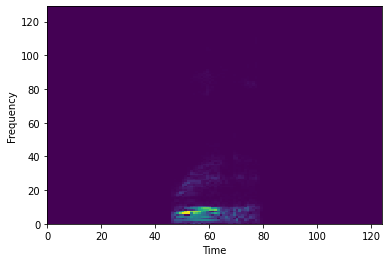

Minimum spectrogram tf.Tensor(1.0693954e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.01681012, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


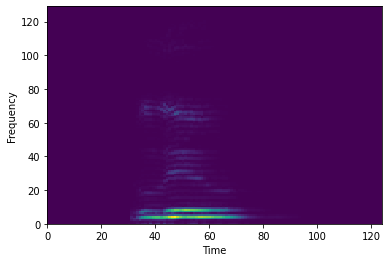

Minimum spectrogram tf.Tensor(1.0693954e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.011905616, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int64)


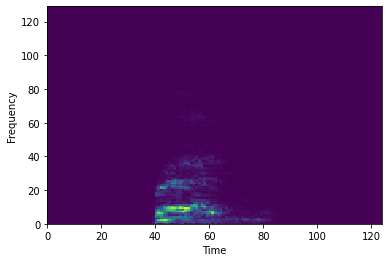

Minimum spectrogram tf.Tensor(1.0693954e-11, shape=(), dtype=float32) Maximum spectrogram value: tf.Tensor(0.010306441, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
#shutil.rmtree("/content/dataset/DEV/unknown")
#shutil.rmtree("/content/dataset/TRAIN/unknown")
#shutil.rmtree("/content/dataset/TEST/unknown")

commands = get_commands(datasetPath)
train_ds = ds_preProcessing("TRAIN") #Initialize and make each dataset split
val_ds = ds_preProcessing("TEST")
test_ds = ds_preProcessing("DEV")

print(train_ds)

for spectrogram, label in test_ds.take(3): #show several spectrograms
  get_spectrogram_plot(spectrogram)
  print("Minimum spectrogram", tf.reduce_min(spectrogram), "Maximum spectrogram value:", tf.reduce_max(spectrogram))
  print(label)

# CNN model training

## Architecture decleration
Creates the CNN model architectures

In [ ]:
for spectrogram, _ in test_ds.take(1): #Get the spectrogram shape and number of labels
  input_shape = spectrogram.shape
  input_example = spectrogram
print('Input shape:', input_shape)
num_labels = len(commands)
print("Number of commands and ending parameters: ", num_labels)

if modelType == "simpleCNN": #Initialize simple CNN architecture
  # Instantiate the `tf.keras.layers.Normalization` layer.
  norm_layer = layers.Normalization()
  # Fit the state of the layer to the spectrograms
  # with `Normalization.adapt`.
  norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
  model = models.Sequential([
      layers.Input(shape=input_shape),
      # Downsample the input.
      layers.Resizing(32, 32),
      # Normalize.
      norm_layer,
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_labels),
      ])
  print("Made an simpleCNN model!")

elif modelType == "mobileNetV1": #Initialize MobileNetV1 architecture
  model = tf.keras.applications.MobileNet(input_shape=input_shape, classes=num_labels, weights=None, 
                                          alpha=alphaMobileNet, dropout=dropoutMobileNet)
  print("Made an mobileNetV1 model!")

elif modelType == "mobileNetV2": #Initialize MobileNetV2 architecture
  model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape, classes=num_labels, weights=None,
                                                         alpha=alphaMobileNet)
  print("Made an mobileNetV2 model!")
elif modelType == "mobileNetV3": #Initialize MobileNetV3 architecture
  mobileNetLayers.layers = tf.keras.applications.MobileNetV3Small(input_shape=input_shape, classes=num_labels, weights=None,  #Load the mobileNet architecture with no weights(not pretrained).
                                    minimalistic=False, include_preprocessing=normalize_spectrogram_bool, alpha=alphaMobileNet, #Can have a "top" meaning it is a full architecture with fully connected layer, or can be False which means a manual fully connected layer should be added
                                    include_top=False, pooling="avg", dropout_rate=0.4) #If include top is false, pooling should be average("avg")
  for layer in mobileNetLayers.layers:
    layer.trainable = True #Set mobilenet layers to be trainable

  model = models.Sequential() #Make new model containing the mobileNet architecture + fully connected layers
  model.add(mobileNetLayers) #Add mobileNet layers to model

  model.add(layers.Dropout(0.25)) #Delete some of the output of the mobileNet layers, reduces chance for overfitting
  model.add(layers.Flatten()) #Flatten the output to a 1D array
  model.add(layers.Dense(128, activation='relu')) #Add fully connected layer that outputs a 128x1 array
  model.add(layers.Dropout(0.5)) #Delete some of the output
  model.add(layers.Dense(num_labels)) #Add another fully connected layer that performs the final prediction, outputs one of the labels

  print("Made an mobileNetV3 model!")

elif modelType == "efficientNet": #Initialize efficientNet architecture(for testing)
  model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=input_shape, weights=None, include_top=True, classes=num_labels, classifier_activation="relu")
  print("Made an efficientNet model!")   

else: print("Error, modeltype not set to valid model")

Input shape: (129, 124, 1)
Number of commands and ending parameters:  3
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 129, 124, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 65, 62, 16)   144         ['input_1[0][0]']                
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 65, 62, 16)  64          ['Conv[0][0]']                   
 tion)                                                                                            
           

NameError: ignored

## Metrics & Callbacks
Configures the metrics and settings of the model that are to be used for training

In [ ]:
#Model settings

optimizer = tf.keras.optimizers.Adam() #Handles the weight itterations of the model during training
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #How to calculate the loss of the model during training, from_logits should be set to True! Atleast for the simpleCNN 
metrics = [tf.keras.metrics.sparse_categorical_accuracy] #How to calculate the performance of the model

model.compile(optimizer=optimizer, loss=loss, metrics=metrics) #Create a usable model with all settings
model.summary() #Display the model architecture

#Training callback settings
weight_path="{}_weights.best.hdf5".format(modelType) #Path where to save the best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, #Saves model weights during training when a new best is found, allows for a backup if training crashes
                             save_best_only=True, mode='min', save_weights_only = True) 
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', #Reduces Learning rate when training stagnates, allows more training to take place
                                   factor=0.8, patience=2, 
                                   verbose=1, mode='auto', 
                                   min_delta=0.0001, cooldown=5, 
                                   min_lr=0.00001)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", #Stops training if the validation loss does not improve for x Epochs(Set by the patience variable)
                      mode="min", 
                      patience=6)
callback_list = [checkpoint, early, reduceLROnPlat] #Afforementioned functions that will be performed after each epoch

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

## Training
Training execution of the model

In [ ]:
train_ds = train_ds.batch(batch_size) #Devides the splits into batches, improves training performance and speed
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE) #Preload the batches
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
if device_name == '/device:GPU:0':
  with tf.device('/device:GPU:0'): #Perform training with GPU device for faster training
    history = model.fit(
      train_ds, batch_size=batch_size,
      validation_data=val_ds,
      callbacks=[callback_list], #Call the callback_list containing the checkpoint saving, learning rate reduction and early stopping after each EPOCH
      epochs=EPOCHS, verbose=1)
else: #If GPU is not available, run on CPU
    history = model.fit(
      train_ds, batch_size=batch_size,
      validation_data=val_ds,
      callbacks=[callback_list],
      epochs=EPOCHS, verbose=1)

Epoch 1/60
154/154 [==============================] - ETA: 0s - loss: 0.5652 - sparse_categorical_accuracy: 0.7979
Epoch 1: val_loss improved from inf to 0.40258, saving model to simpleCNN_weights.best.hdf5
154/154 [==============================] - 22s 85ms/step - loss: 0.5652 - sparse_categorical_accuracy: 0.7979 - val_loss: 0.4026 - val_sparse_categorical_accuracy: 0.8674 - lr: 0.0010
Epoch 2/60
144/154 [===========================>..] - ETA: 0s - loss: 0.3909 - sparse_categorical_accuracy: 0.8567
Epoch 2: val_loss improved from 0.40258 to 0.32103, saving model to simpleCNN_weights.best.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 0.3884 - sparse_categorical_accuracy: 0.8566 - val_loss: 0.3210 - val_sparse_categorical_accuracy: 0.8923 - lr: 0.0010
Epoch 3/60
144/154 [===========================>..] - ETA: 0s - loss: 0.3270 - sparse_categorical_accuracy: 0.8808
Epoch 3: val_loss improved from 0.32103 to 0.31336, saving model to simpleCNN_weights.best.hdf5
154/1

## Performance
Analyse the performance of the trained model, via the use of the training graphs and confusion matrix

Succesfully saved training graph


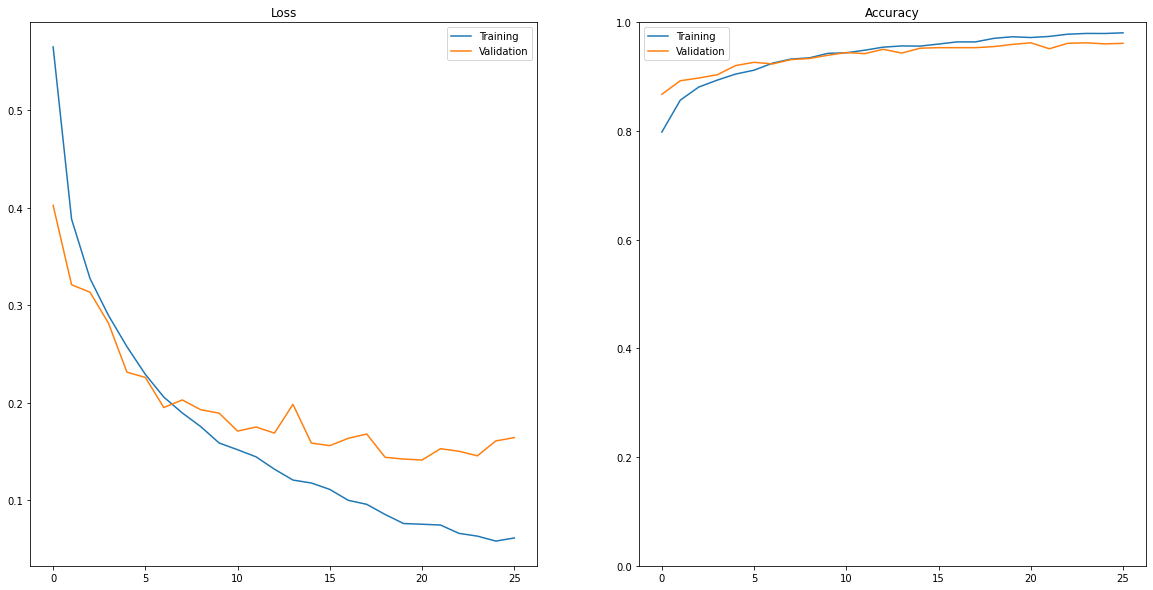

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10)) #Display losses and accuracy in a plot
ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(history.history['sparse_categorical_accuracy'], label='Training')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
ax2.legend()
ax2.set_title('Accuracy')
ax2.set_ylim(0, 1)

try:
  os.mkdir("/content/results")  #Save figure as PNG, in order to save as metadata later
  fig.savefig("/content/results/training_graph.png")
except:
  print("Failed to save history figures")

print("Succesfully saved training graph")

Creation of the confusion matrix, based on the test split

Labels:  (1003,)
Test set accuracy: 96%
Succesfully saved confusion matrix


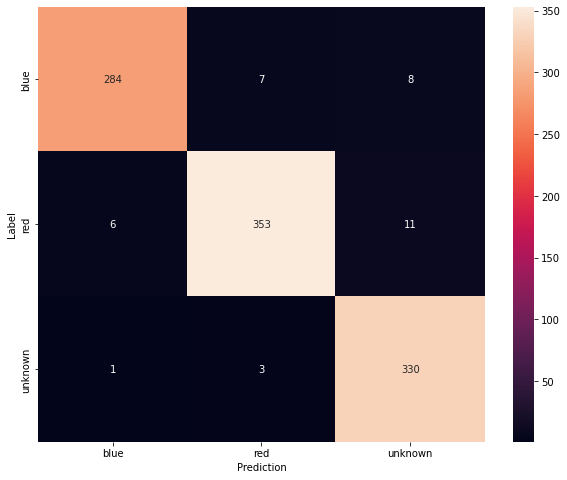

In [ ]:
test_spectrogram = []
test_labels = []

for spectrogram, label in test_ds:  #Preload the test split
  test_spectrogram.append(spectrogram.numpy())
  test_labels.append(label.numpy())

test_spectrogram = np.array(test_spectrogram)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_spectrogram), axis=1) #Make predictions of the test split
y_true = test_labels
print("Labels: ", test_labels.shape)

test_acc = sum(y_pred == y_true) / len(y_true) #Calculate test split accuracy
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) #Calculate confusion matrix based on predictions and true labels
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')

try:
  plt.savefig("/content/results/confusion_matrix.png") #Save confusion matrix as PNG
except:
  print("Failed to save confusion matrix")

print("Succesfully saved confusion matrix")
plt.show()

# Saving trained model
Saving the trained model to Google Drive, both in normal and TFLite versions.

In [ ]:
try: 
  drive.mount("/content/gdrive", force_remount=False) #Check if Google Drive is still mounted
  print("Google Drive succes!")
except:
  print("Error")

modelName, tfLiteModel_name = get_model_name() #Get next available model name, and create the name based on parameters

try:
  if os.path.exists(modelSavePath) != True: os.makedirs(modelSavePath)
  modelPath = "/content/gdrive/MyDrive/Saved_models/" + modelName
  model.save(filepath=modelPath, overwrite=False, save_format='tf') #Save model as normal TF model
except:
  print("Error")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive succes!
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Saved_models/V5.0_simpleCNN_MSWC_blue-red-unknown_spectrogram_05-04-2022/assets


Convert and save as TFlite version

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(modelPath) # Path to the SavedModel directory
tflite_model = converter.convert()  #Convert normal TF model to TF Lite version

if os.path.exists(modelSavePath / "tfLite_models/") != True: os.makedirs(modelSavePath / "tfLite_models/") #Check if directory exists

# Save the model.
with open(tfLiteModel_name, 'wb') as f:
  f.write(tflite_model)

shutil.copyfile(tfLiteModel_name, (modelSavePath / "tfLite_models" / (tfLiteModel_name + ".tflite"))) #Move to GoogleDrive

PosixPath('/content/gdrive/MyDrive/Saved_models/tfLite_models/V5.0_TFlite_simpleCNN_MSWC_blue-red-unknown_spectrogram_05-04-2022.tflite')

Save meta data, containing the training graphs and confusion matrix to the model directory.

Also adds a .CSV containing all the parameters that were used

In [ ]:
#Save model Meta Data
#Comments from user to be saved in meta data
userComments = "Normal 1D spectrogram 129x124, from_logits=True in sparsecatagoricalAccuracy"

try:
  metaDataPath = (modelPath + "/metadata") #Move result pictures to the corresponding model in GoogleDrive
  os.mkdir(metaDataPath)
  shutil.move("/content/results/training_graph.png", (metaDataPath + "/training_graph.png"))
  shutil.move("/content/results/confusion_matrix.png", (metaDataPath + "/confusion_matrix.png"))
except:
  print("Could not create metadata directory in saved model")

if data_augmentation_bool != True: 
  augmentation_chance = 0 
  shift_percentage = 0 #Set chances to 0 if augmentation is not performed
  noise_percentage = 0 

headerMeta = ["ModelName", "Test split accuracy" , "CNN", "Dataset", "TF_Version", "Data augmentation percentage", "Time shift percentage", "Noise addition percentage",
              "Noise SNR", "Normalize Spectrogram", "Sample Rate", "Window length(Spectro)", "Hop length(Spectro)", "NFFT size", "Epochs", 
              "Batch size", "Comments"]

dataRowMeta = [modelName, test_acc, modelType, datasetType, str(tf. __version__), augmentation_chance, shift_percentage, noise_percentage,
           desired_snr, str(normalize_spectrogram_bool), sampleRate, sampleSegment, sampleHop, nfftSize, EPOCHS,
           batch_size, userComments]

with open((metaDataPath + "/metadata.csv"), 'w', encoding='UTF8') as f:
  writer = csv.writer(f)
  writer.writerow(headerMeta) #Save metadata as CSV in corresponding model
  writer.writerow(dataRowMeta)
print("Succesfully saved metadata CSV")

Succesfully saved metadata CSV


# Testing model with custom dataset

In [ ]:
try: 
  drive.mount("/content/gdrive", force_remount=False) #Check if Google Drive is still mounted
  print("Google Drive succes!")
except:
  print("Error")

if os.path.exists(custom_dataset_path) != True: 
  print("Error, dataset path does not exist")
  sys.exit()
if 'model' in locals(): #Checks if a model was already trained this session, otherwise allows for the selection of a pretrained model located in the Google Drive
  print("Model already loaded, continueing")
else:
  print("Model not yet loaded, input model string to load:")
  print(os.listdir(modelSavePath))
  model_to_load = input("Model to load: ") #User input of the model to be loaded
  model = tf.keras.models.load_model(str(modelSavePath / model_to_load))
  commands = get_commands(datasetPath) #Gets the available commands, as they were not yet loaded

all_custom_paths = tf.io.gfile.glob(str(custom_dataset_path / "*")) #Loads all the files in the custom dataset folder
total_amount_frames = 0
total_amount_wrong_predictions = 0
time_interference_array = []
time_processing_array = []

for index, path_custom in enumerate(all_custom_paths):
  wrong_predictions_time = ["Time of detected command(seconds): "]
  wrong_predictions_label = ["Detected command: "]

  encoded_custom = tf.io.read_file(path_custom) #Read file and decode
  custom_audio, _ = tf.audio.decode_wav(contents=encoded_custom)
  custom_audio, _ = tf.unstack(custom_audio, axis=-1) #Remove stereo channel, make mono
  custom_frames = tf.signal.frame(custom_audio, 16000, 8000, pad_end=True) #Chop the file into 1 second segments, uses an hopLength of 0.5s
  total_amount_frames = total_amount_frames + custom_frames.shape[0] #Saves the amount of frames for the accuracy calculation

  for frame_number, frame in enumerate(custom_frames):
    start = time.perf_counter()
    custom_spectrogram = get_spectrogram(frame) #Convert audio to a spectrogram
    custom_spectrogram = tf.expand_dims(custom_spectrogram, axis=0) #Add another dimension as this is expected by the model
    time_processing_array.append(time.perf_counter() - start) #Saves the time that was needed for preprocessing to a spectrogram

    start = time.perf_counter()
    predicted_label = np.argmax(model(custom_spectrogram), axis=1) #Perform inference and save the predicted label
    time_interference_array.append(time.perf_counter() - start) #Saves the time needed for inference

    if predicted_label != 2: #Checks if the predicted label is not "unknown"
      seconds = get_seconds(frame_number) #Gets the location in seconds where the prediction occured
      wrong_predictions_time.append(seconds)  #Save the time and predicted command
      wrong_predictions_label.append(commands[predicted_label.item()])
      total_amount_wrong_predictions += 1 #Keep track of the amount of wrong predictions

  print("file being read: ", path_custom)
  file_name_entire = path_custom.split("/")
  file_name_entire = file_name_entire[-1].split(".")
  shortened_file_name = file_name_entire[0].split("__")[0] #Gets a shortened filename of the .WAV

  if "modelName" in locals(): #Checks if a modelName is already present in the loaded variables
    if os.path.exists(modelPath + "/custom_dataset_results") != True: 
      os.mkdir((modelPath + "/custom_dataset_results"))
    file_name = modelPath + "/custom_dataset_results/" + shortened_file_name + "_" + modelName + ".csv" #Set the filename of the .CSV
  else:
    if os.path.exists(str(modelSavePath / model_to_load / "custom_dataset_results")) != True:
      os.mkdir(str(modelSavePath / model_to_load / "custom_dataset_results"))
    file_name = str(modelSavePath / model_to_load / "custom_dataset_results") + "/" + shortened_file_name + "_" + model_to_load + ".csv"

  wrong_predictions = np.array([wrong_predictions_time, wrong_predictions_label])
  wrong_predictions.transpose()
  np.savetxt(file_name, wrong_predictions, delimiter=",", fmt="%s") #Save the results into a .CSV and store it inside of the model that was used
  print("Done predicting file, results saved in model folder")

print()
print()
print("Done with custom dataset predictions")
accuracy_custom_test = 100 - ((total_amount_wrong_predictions / total_amount_frames) * 100) #Accuracy calculation
print("Accuracy on the test set: ", "%.2f" % accuracy_custom_test, "%")
print("Amount of wrong predictions:", total_amount_wrong_predictions)

print()
print('Average interference time in milliseconds.', tf.reduce_mean(time_interference_array).numpy()*1000) #Show the average time, says little about the actual performance on the Raspberry Pi
print('Average processing time in milliseconds.', tf.reduce_mean(time_processing_array).numpy()*1000)
print("Average total time.", (tf.reduce_mean(time_interference_array).numpy()*1000) + (tf.reduce_mean(time_processing_array).numpy()*1000))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive succes!
Model already loaded, continueing
file being read:  /content/gdrive/MyDrive/Datasets/Real-life_Verification/MTest3__commands+noise_noGain_quick.wav
Done predicting file, results saved in model folder
file being read:  /content/gdrive/MyDrive/Datasets/Real-life_Verification/MTest2__commands+noise_equalSNR_slow.wav
Done predicting file, results saved in model folder
file being read:  /content/gdrive/MyDrive/Datasets/Real-life_Verification/Mtest1__commands+noise_equalSNR_quick.wav
Done predicting file, results saved in model folder
file being read:  /content/gdrive/MyDrive/Datasets/Real-life_Verification/MTest6__commands+noise_5SNR_slow.wav
Done predicting file, results saved in model folder
file being read:  /content/gdrive/MyDrive/Datasets/Real-life_Verification/MTest5__commands+noise_5SNR_quick.wav
Done predicting file, results saved in